<a href="https://colab.research.google.com/github/insancs/clean-messy-rooms/blob/main/CNN_Clean_vs_Messy_Room.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Download Dataset

In [20]:
!wget --no-check-certificate \
  https://github.com/dicodingacademy/assets/raw/main/ml_pemula_academy/messy-vs-clean-room.zip \
  -O /tmp/messy_vs_clean_room.zip

--2021-10-12 13:52:56--  https://github.com/dicodingacademy/assets/raw/main/ml_pemula_academy/messy-vs-clean-room.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dicodingacademy/assets/main/ml_pemula_academy/messy-vs-clean-room.zip [following]
--2021-10-12 13:52:57--  https://raw.githubusercontent.com/dicodingacademy/assets/main/ml_pemula_academy/messy-vs-clean-room.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70392746 (67M) [application/zip]
Saving to: ‘/tmp/messy_vs_clean_room.zip’

/tmp/messy_vs_clean 100%[===================>]  67.13M   121MB/s    in 0.6s    

2021-10-12 13:53:01 

# Extract Dataset

In [21]:
# melakukan ekstraksi pada file zip
import zipfile,os
local_zip = '/tmp/messy_vs_clean_room.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [22]:
os.listdir('/tmp/images/train')

['clean', 'messy']

In [23]:
os.listdir('/tmp/images/val')

['clean', 'messy']

In [24]:
# membuat direktori ruangan rapi pada direktori data training
train_clean_dir = os.path.join(train_dir, 'clean')

# membuat direktori ruangan berantakan pada direktori data training
train_messy_dir = os.path.join(train_dir, 'messy')

# membuat direktori ruangan rapi pada direktori data validasi
validation_clean_dir = os.path.join(validation_dir, 'clean')

# membuat direktori ruangan berantakan pada direktori data validasi
validation_messy_dir = os.path.join(validation_dir, 'messy')

# Image Augmentation

In [25]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [26]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4,
        # karena ini merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4, # karena ini merupakan masalah klasifikasi 2 kelas maka menggunakan class_mode = 'binary'
        class_mode='binary')

Found 192 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


# Build CNN Model

In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 512)      

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=25,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
)

Epoch 1/25
25/25 [==============================] - 9s 333ms/step - loss: 0.7206 - accuracy: 0.5200 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/25
25/25 [==============================] - 8s 316ms/step - loss: 0.6939 - accuracy: 0.4900 - val_loss: 0.6923 - val_accuracy: 0.6000
Epoch 3/25
25/25 [==============================] - 8s 321ms/step - loss: 0.6894 - accuracy: 0.6100 - val_loss: 0.8558 - val_accuracy: 0.5500
Epoch 4/25
25/25 [==============================] - 8s 316ms/step - loss: 0.6431 - accuracy: 0.6200 - val_loss: 0.6633 - val_accuracy: 0.5000
Epoch 5/25
25/25 [==============================] - 8s 318ms/step - loss: 0.6739 - accuracy: 0.4900 - val_loss: 0.6203 - val_accuracy: 0.7000
Epoch 6/25
25/25 [==============================] - 8s 316ms/step - loss: 0.5657 - accuracy: 0.7500 - val_loss: 0.4155 - val_accuracy: 0.8000
Epoch 7/25
25/25 [==============================] - 8s 320ms/step - loss: 0.5872 - accuracy: 0.6900 - val_loss: 0.5311 - val_accuracy: 0.7000
Epoch 

# Plotting Accuracy and Loss

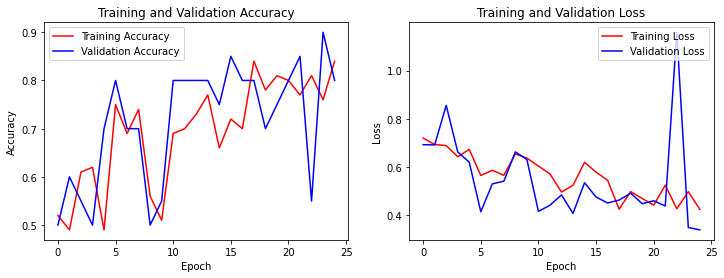

In [30]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12,4)

# Define accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Define loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plotting accuracy
ax[0].plot(epochs, acc, 'r', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='upper left')

# Plotting loss 
ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper left')

plt.show()

# Predict Image

Saving c.jpg to c (1).jpg
c.jpg
The room is clean


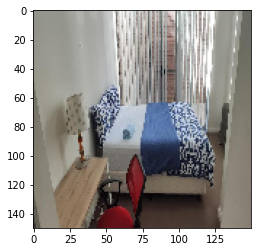

In [31]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes==0:
    print('The room is clean')
  else:
    print('The room is messy')

In [63]:
# Define predict function
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array * (1/225)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis='columns')
  rooms = ['clean', 'messy']

  df['Rooms'] = rooms
  df = df[['Rooms', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
    predict_room = 'Clean'
  else:
    predict_room = 'Messy'

  return predict_room, df

Saving c.jpg to c (12).jpg


ValueError: ignored

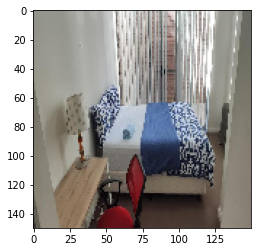

In [65]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')